In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim

from data_loader import load_dataset
from model_trainer import train

PATH_TRAIN = "../Data/Processed/Train.nc"
PATH_TEST = "../Data/Processed/Test.nc"
PATH_VAL = "../Data/Processed/Val.nc"

PATH_WEIGHTS_BEST = "../Models/PINN-Best.pth"
PATH_WEIGHTS_CURRENT = "../Models/PINN-Current.pth"

NUM_FEATURES = 3

The architecture of this model is based on the following diagram, which was taken from the "PINN" paper in the Bibliography section

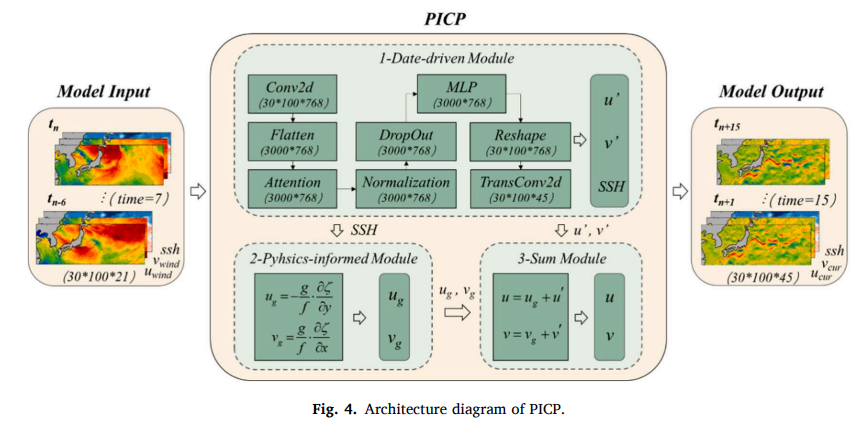

In [ ]:
class DataDrivenModule(nn.Module):
    def __init__(self, 
                 in_channels=21, out_channels=768, kernel_size=(5, 10), 
                 embed_dim=768, num_heads=4, 
                 dropout_p=0.1, 
                 mlp_hidden_dim=768,  
                 transconv_out_channels=45):
        super(DataDrivenModule, self).__init__()
        
        self.conv = nn.Conv2d(in_channels=in_channels, out_channels=out_channels, kernel_size=kernel_size)
        self.attn = nn.MultiheadAttention(embed_dim=embed_dim, num_heads=num_heads, batch_first=True)
        self.dropout = nn.Dropout(p=dropout_p)
        self.norm = nn.LayerNorm(embed_dim)
        self.mlp = nn.Sequential(
            nn.Linear(embed_dim, mlp_hidden_dim),
            nn.ReLU(),
            nn.Linear(mlp_hidden_dim, mlp_hidden_dim),
            nn.ReLU(),
            nn.Linear(mlp_hidden_dim, out_channels),
            nn.ReLU()
        )
        self.transconv = nn.ConvTranspose2d(in_channels=out_channels, out_channels=transconv_out_channels, kernel_size=kernel_size)

    def forward(self, x):
        batch_size, channels, height, width = x.shape

        x = self.conv(x)
        x = x.flatten(start_dim=2).permute(0, 2, 1)
        x, _ = self.attn(x, x, x)
        x = self.norm(x)
        x = self.dropout(x)
        x = self.mlp(x)
        x = x.permute(0, 2, 1).view(batch_size, -1, height, width)
        x = self.transconv(x)
        
        return x  # Returns u', v', SSH

In [ ]:
class PhysicsInformedModule(nn.Module):
    def __init__(self, g=9.81, f=1e-4):
        super(PhysicsInformedModule, self).__init__()
        self.g = g
        self.f = f

    def forward(self, ssh):
        # Compute gradients ∂SSH/∂x and ∂SSH/∂y using finite differences
        dudx = torch.diff(ssh, dim=-1, append=ssh[:, :, :, -1:])
        dvdy = torch.diff(ssh, dim=-2, append=ssh[:, :, -1:, :])
        
        # Compute geostrophic velocity components
        u_g = self.g / self.f * dvdy
        v_g = -self.g / self.f * dudx
        return u_g, v_g
    
class SumModule(nn.Module):
    def forward(self, u_g, v_g, u_prime, v_prime):
        u = u_g + u_prime
        v = v_g + v_prime
        return u, v

In [ ]:
class PICPModel(nn.Module):
    def __init__(self, input_days=7, target_days=15, kernel_size=(5, 10), num_heads=4):
        super(PICPModel, self).__init__()
        self.data_module = DataDrivenModule(in_channels=input_days * NUM_FEATURES, 
                                            transconv_out_channels=target_days * NUM_FEATURES, 
                                            kernel_size=kernel_size, 
                                            num_heads=num_heads)
        self.physics_module = PhysicsInformedModule()
        self.sum_module = SumModule()

    def forward(self, x):
        # Step 1: Data-driven module
        output = self.data_module(x)
        u_prime, v_prime, ssh = torch.chunk(output, chunks=3, dim=1)

        # Step 2: Physics-informed module
        u_g, v_g = self.physics_module(ssh)

        # Step 3: Sum module
        u, v = self.sum_module(u_g, v_g, u_prime, v_prime)

        return torch.stack((u, v), dim=1)

In [ ]:
class WeightedLoss(nn.Module):
    def __init__(self, rho=2.0):
        super(WeightedLoss, self).__init__()
        self.rho = rho
        self.mse = nn.MSELoss(reduction='none')

    def forward(self, predictions, targets):
        # Compute SSC magnitude
        ssc = torch.sqrt(targets[:, 0, :, :]**2 + targets[:, 1, :, :]**2)

        # Compute 85th percentile threshold (U_max15%)
        U0 = torch.quantile(ssc, 0.85) if ssc.numel() > 0 else 0.0

        # Create weight matrix (rho for high SSC, 1 otherwise)
        weight = torch.ones_like(ssc)
        weight[ssc > U0] = self.rho

        # Compute weighted MSE loss
        loss = self.mse(predictions, targets)
        loss = weight.unsqueeze(1) * loss
        return loss.mean()

In [ ]:
kernel_size = (5, 10)
num_heads = 4
rho = 3.0

input_days = 7
target_days = 15

epochs = 10
batch_size = 8
learning_rate = 0.001

model = PICPModel(kernel_size=kernel_size, num_heads=num_heads)
loss_function = WeightedLoss(rho=rho)
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

train_ds = load_dataset(PATH_TEST, batch_size=batch_size)
val_ds = load_dataset(PATH_VAL, batch_size=batch_size)

In [ ]:
metrics = train(model = model,
                loss_function = loss_function, 
                optimizer = optimizer,
                train = train_ds, 
                val = val_ds,
                num_epochs = epochs, 
                path_weights_best = PATH_WEIGHTS_BEST, 
                path_weights_last = PATH_WEIGHTS_CURRENT)